In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

sns.set_theme(
    context="poster",
    style="whitegrid",
    rc={
        "figure.figsize": (7.0, 7.0),
        "figure.dpi": 150,
        "savefig.dpi": 1000,
        "figure.constrained_layout.use": True,
        "pdf.fonttype": 42,
    },
)

# Parse MTT Data

In [40]:
df_cnn = pd.read_csv("../data/out/generalization/e7ivqipk.csv")
df_cnn["filter"] = "cnn"
df_lmb = pd.read_csv("../data/out/lmb_summary.csv")
df_glmb = pd.read_csv("../data/out/glmb_summary.csv")
df_combined = pd.concat([df_cnn, df_lmb, df_glmb]).reset_index(drop=True)
data = (
    df_combined.groupby(["filter", "scale", "simulation_idx"], as_index=False)
    .mean()
    .replace({"cnn": "CNN", "lmb": "LMB", "glmb": "GLMB"})
    .rename(columns={"filter": "Filter"})
)

# Parse MID Data

In [36]:
data_path = Path("/nfs/general/mid_data/stats")
filenames = list(data_path.glob("*.npy"))
# filenames = [data_path / "256.npy", data_path / "512.npy"]


def load_scale(filename: Path) -> pd.DataFrame:
    # filename of form {img_size}.npy
    img_size = int(filename.stem)
    data = np.load(filename)
    # columns of data: opt_conn, cnn_conn, cnn_power, opt_count, cnn_count, avg_power
    # keep only the ones relating to cnn
    return pd.DataFrame(
        {
            "img_size": img_size,
            "connectivity": data[:, 1],
            "power": data[:, 2],
            "n_comm": data[:, 4],
        }
    )


df = pd.concat([load_scale(f) for f in filenames], axis=0, ignore_index=True)

# remove values with power == 0
df = df[df["power"] > 0]

meters_per_pixel = 1.25
df["width"] = (df["img_size"] * 1.25).astype(int)

# Make Figure

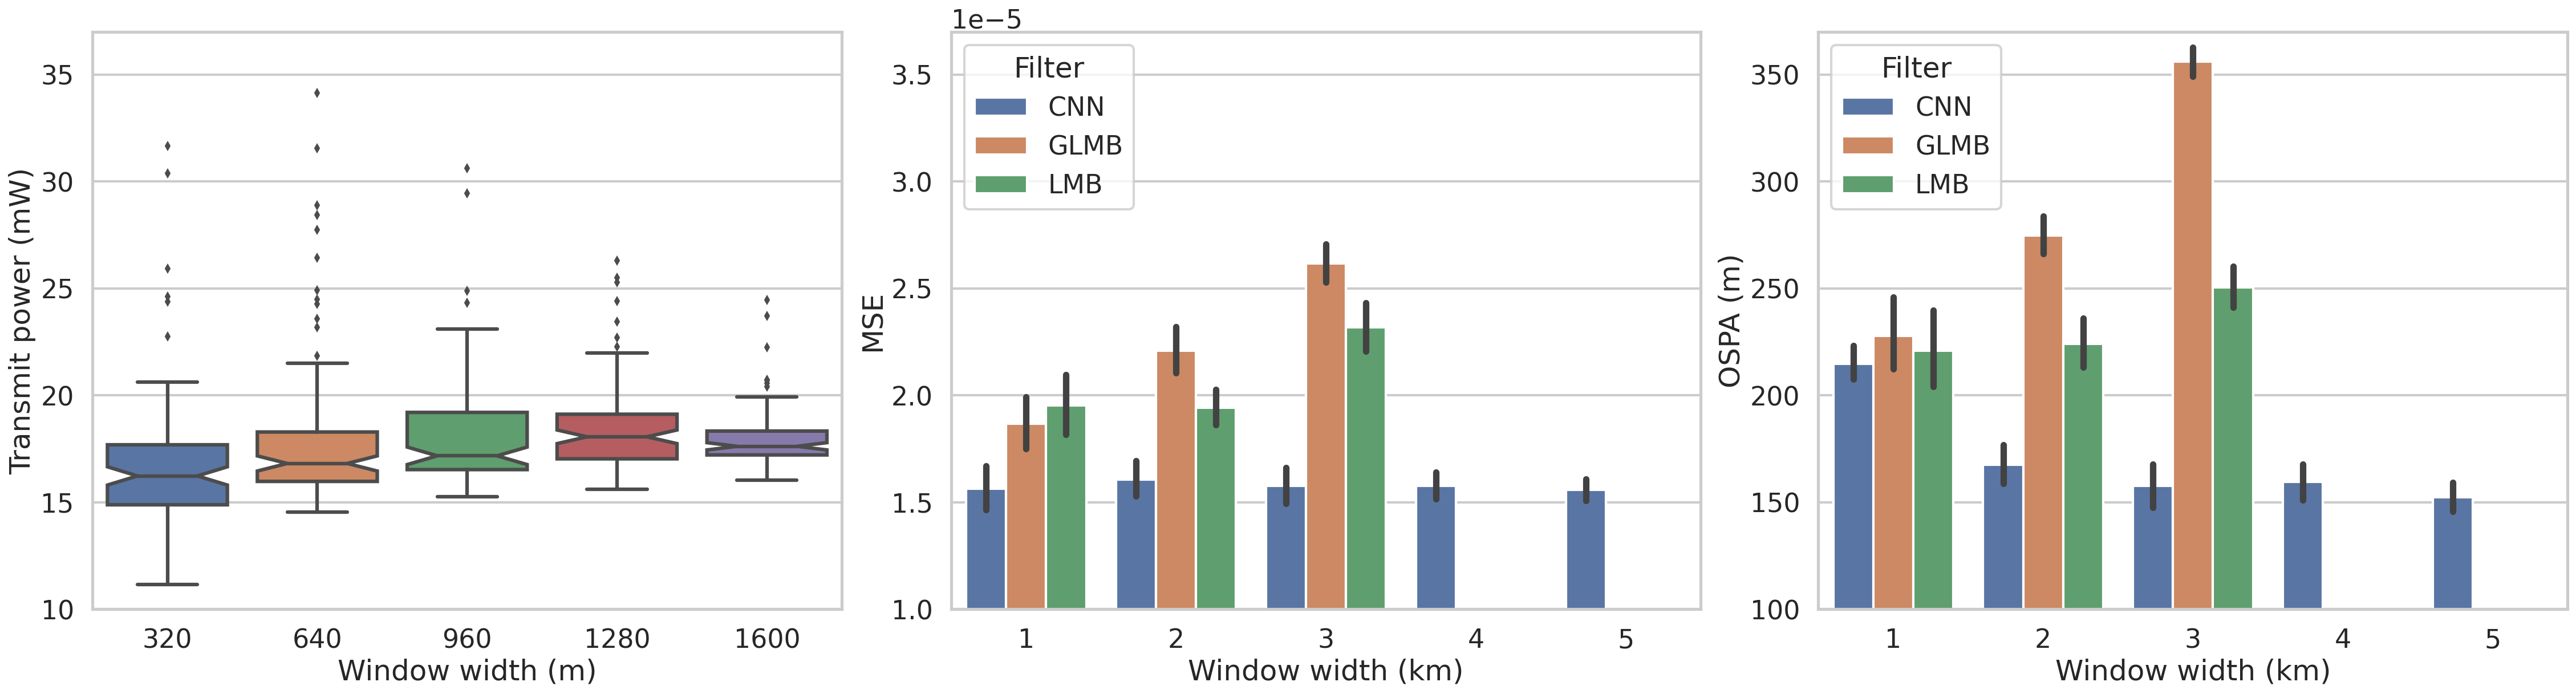

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(30, 8))

sns.boxplot(ax=ax[0], data=df, x="width", y="power", notch=True)
ax[0].set_xlabel("Window width (m)")
ax[0].set_ylabel("Transmit power (mW)")
ax[0].set_ylim(10, 37)

sns.barplot(ax=ax[1], data=data, x="scale", y="mse", hue="Filter", errorbar="ci")
# plt.legend(
#     loc="center",
#     bbox_to_anchor=(1.1, -0.3, -1.2, 0.1),
#     ncols=3,
#     title=None,
#     fontsize="x-small",
# )
ax[1].set_ylabel("MSE")
ax[1].set_xlabel("Window width (km)")
ax[1].set_ylim(1e-5, 3.7e-5)

sns.barplot(ax=ax[2], data=data, x="scale", y="ospa", hue="Filter", errorbar="ci")
# plt.legend(
#     loc="center",
#     bbox_to_anchor=(1.1, -0.3, -1.2, 0.1),
#     ncols=3,
#     title=None,
#     fontsize="x-small",
# )
ax[2].set_ylabel("OSPA (m)")
ax[2].set_xlabel("Window width (km)")
ax[2].set_ylim(100, 370)

plt.savefig("../figures/poster/combined.pdf", bbox_inches="tight")
plt.show()